In [ ]:
# !pip install keras
# !pip install tensorflow==2.3.0

In [ ]:
#  !pip install --upgrade tensorflow_hub

Requirement already up-to-date: tensorflow_hub in /usr/local/lib/python3.6/dist-packages (0.9.0)


In [2]:
##코랩실행시 google driver mount 하기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')
% cd /content/drive/My Drive/Diagnosis_Gallbladder_Cancer

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Diagnosis_Gallbladder_Cancer


In [3]:
!pip install pydicom
!pip install imgaug

In [4]:
import pydicom as pdc
import matplotlib.pyplot as plt
from IPython.display import display, Image
import numpy as np
import cv2
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout
# import tensorflow_hub as hub
%pylab inline
import glob
from PIL import Image
import os

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# # local 에서 실행시
# # get current path
# print("current file path: ",os.getcwd())

# #change Path
# new_path=os.chdir('../')
# print("new path:",new_path)


In [ ]:
path = 'metadata/'
# Load Meta-data and preprocessing
patient_meta = pd.read_csv(path + 'patient_meta.csv')
patient_meta = patient_meta[['RANDOM_PT_NO','SEX','AGE',"DX"]]
#patient_meta.head()

#NET, Lymphoma : Dropped (3 cases)
print("Drop:", patient_meta[(patient_meta['DX']=='lymphoma') | (patient_meta['DX']=='NET')].index)
patient_meta = patient_meta.drop(patient_meta[(patient_meta['DX']=='lymphoma') | (patient_meta['DX']=='NET')].index, axis=0)
patient_meta.reset_index(drop=True, inplace=True)

# categorical Variables(Sex, Phase)
# pd.get_dummies() 가변수 만들기
patient_meta = pd.concat([patient_meta, pd.get_dummies(patient_meta[['SEX']])], axis=1)
patient_meta = patient_meta.drop(['SEX'], axis=1)

# Continuous Variables(Age)
age = patient_meta['AGE'].values
age_scaled = preprocessing.scale(age)
 
patient_meta['AGE_NORM'] = age_scaled
patient_meta = patient_meta.drop(['AGE'], axis = 1)

#Label Setting
# 1 : Metastasis, 56
# 2 : Hepatocelluar Carcinoma, 30
# 3 : cholangiocarcinoma, 14 --> ????    # 숫자가 의미하는 것은??
for r in range(patient_meta.shape[0]):
    if('metastasis' in patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 1
    elif('HCC' == patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 2
    elif('cholangiocarcinoma' == patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 3
    else:
        patient_meta.iloc[r, 1] = 0

print(patient_meta.head())
patient_meta = np.array(patient_meta)   #넘파이 배열로 변환
# patient_meta.shape

Drop: Int64Index([42, 66, 69], dtype='int64')
  RANDOM_PT_NO DX  SEX_f  SEX_m  AGE_NORM
0   SN00180816  2      0      1 -0.971709
1   SN00361989  2      1      0 -1.065503
2   SN00481545  3      1      0  0.904177
3   SN00493709  3      0      1  0.435205
4   SN00181638  1      0      1 -0.315149


In [ ]:
label_df = pd.read_csv('metadata/label_df.csv')
label_df.head()

,patient_no,img_idx,mean_annotation,DX
0,SN00017916,1,0.0,0
1,SN00017916,2,0.0,0
2,SN00017916,3,0.0,0
3,SN00017916,4,0.0,0
4,SN00017916,5,0.0,0


In [ ]:
# # 1 patient 당 DX list 가져오기
grouped_df=label_df.groupby('patient_no').agg(list)
temp_list=grouped_df.loc['SN00017916','DX']

In [ ]:
#  sorted(glob.glob('./benchmark_liver_tumor/raw/'+'SN00017916'+'/*.dcm'))
pdc.dcmread('./benchmark_liver_tumor/raw/SN00017916/SN00017916_0020.dcm').pixel_array.shape

(512, 512)

In [ ]:
print(f"한개의 dcm 이미지가 세로, 가로 각각 {512/32}개로 나뉘어져 총 {(512/32)**2}개의 pixel로 나눠져야함" )

한개의 dcm 이미지가 세로, 가로 각각 16.0개로 나뉘어져 총 256.0개의 pixel로 나눠져야함


In [ ]:
# Save Dataset
save_path = 'models/original_size_np/'

In [ ]:
path = 'metadata/'
# Load Meta-data and preprocessing
patient_dx = pd.read_csv(path + 'patient_meta.csv')
patient_dx = patient_dx[['RANDOM_PT_NO',"DX"]]
#patient_meta.head()

#NET, Lymphoma : Dropped (3 cases)
print("Drop:", patient_dx[(patient_dx['DX']=='lymphoma') | (patient_dx['DX']=='NET')].index)
patient_dx = patient_dx.drop(patient_dx[(patient_dx['DX']=='lymphoma') | (patient_dx['DX']=='NET')].index, axis=0)
patient_dx.reset_index(drop=True, inplace=True)

def find_disease(patient_no):
    dx=np.array(patient_dx[patient_dx['RANDOM_PT_NO'] == patient_no]['DX'])[0]
    if 'metastasis'in dx:
        return 1
    elif dx == 'HCC':
        return 2
    elif dx == 'cholangiocarcinoma':
        return 3
    else:
        print(f"input error: wrong patient number {patient_no}")

Drop: Int64Index([42, 66, 69], dtype='int64')


## Make Dataset(npy files)

In [ ]:
# 1 patient 당 DX list 가져오기
# sliding-window Proprocessing (길이가 다른 z 축데이터를 동일하게 만들어준다.)
window_size = 5
size = (64,64) #resize 임시로 함(서버 사용 불가능할 때)
n_ct_statistics=[]
# 10-cv Settings
kf = KFold(n_splits=5, random_state=100, shuffle=True)
for tr_list, te_list in kf.split(patient_meta):
    # Save Dataset
    path = 'models/original_size_np/'
    # Train Dataset
    X_p_tr, X_m_tr, X_i_tr, Y_tr = [], [], [], []

    ####### X train
    for tr_idx in tr_list:
        patient_no = patient_meta[tr_idx, 0]
        X_i_tr_ct_list =  sorted(glob.glob('./benchmark_liver_tumor/raw/'+patient_no+'/*.dcm'))
        n_ct = len(X_i_tr_ct_list)
        # Load 3D CT Data per Patient
        ct_block = [] #사진
        label_block = [] # annotation label
        for z in range(n_ct):
#             ct_block.append(cv2.resize(cv2.normalize(pdc.dcmread(X_i_tr_ct_list[z]).pixel_array, dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F), dsize=size))
            ct_block.append(cv2.normalize(cv2.resize(pdc.dcmread(X_i_tr_ct_list[z]).pixel_array,dsize=size), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F))
        ct_block = np.array(ct_block)
        # Sliding-window Preprocess
        n_window = n_ct-window_size+1
        X_i_tr_buffer = [] # window size 만큼 겹쳐서 잘라진 3d 이미지
#         DX_list=grouped_df.loc[patient_no,'DX']# 1 patient 당 DX list 가져오기
        for z in range(n_window):
            X_i_tr_buffer.append(ct_block[z:z+window_size]) # buffer에 겹쳐서 들어감
            # dx = find_disease(patient_no) if np.mean([label.mean() for label in label_block[z:z+window_size]]) >0.0 else 0
            X_p_tr.append(patient_no)# patient number
            X_m_tr.append(patient_meta[tr_idx, 2:])#meta 정보 전체 

        X_i_tr_buffer = np.array(X_i_tr_buffer)
        X_i_tr.extend(X_i_tr_buffer)
        print(f"{patient_no} X train done!")

    X_p_tr, X_m_tr, X_i_tr= np.array(X_p_tr), np.array(X_m_tr), np.array(X_i_tr)
    print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape)
    np.save(save_path+'np_rep/X_p_tr', X_p_tr), np.save(save_path+'np_rep/X_m_tr', X_m_tr), np.save(save_path+'np_rep/X_i_tr', X_i_tr)
    del(X_p_tr)
    del(X_m_tr)
    del(X_i_tr)
    del(X_i_tr_buffer)

    print("train X done!")
    print("="*20)

#########################################################
# Y train
    for tr_idx in tr_list:
        patient_no = patient_meta[tr_idx, 0]
        Y_i_tr_label_list =  sorted(glob.glob('./benchmark_liver_tumor/raw/'+patient_no+'/label/*.png'))
        n_ct = len(Y_i_tr_label_list)

        # Load 3D CT Data per Patient
        label_block = np.zeros(shape=(n_ct)) # annotation label
        label_block[:] = find_disease(patient_no)

        # Sliding-window Preprocess
        n_window = n_ct-window_size+1
#         DX_list=grouped_df.loc[patient_no,'DX']# 1 patient 당 DX list 가져오기
        Y_i_tr_buffer = []
        for z in range(n_window):
            # dx = find_disease(patient_no) if np.mean([label.mean() for label in label_block[z:z+window_size]]) >0.0 else 0
            Y_i_tr_buffer.append(label_block[z:z+window_size]) #buffer에 annotation 겹쳐서 들어감
#             Y_tr.append(patient_meta[tr_idx, 1]) 
            # Y_tr.append(max(DX_list[z:z+window_size])) # label df에서 환자정보, 몇번째 사진인지  input을 넣어주면 dx중에서 max를 가져옴
        Y_i_tr_buffer = np.array(Y_i_tr_buffer)
        Y_tr.extend(Y_i_tr_buffer)
        print(f"{patient_no} Y train done!")
    Y_tr =  np.array(Y_tr)
    print( Y_tr.shape)
    np.save(save_path+'np_rep/Y_tr_repetitive', Y_tr)
    del(Y_tr)
    del(Y_i_tr_buffer)
    print("Y train done!")
    print("="*20)


#---------------------------------------------------------------------------------------------------------------------

    # patient number, meta정보, window size 갯수만큼 겹쳐진 CT 사진, window 마다 y값(max함)
    # Test Dataset
    X_p_te, X_m_te, X_i_te, Y_te = [], [], [], []

    # X Test 
    for te_idx in te_list:
        patient_no = patient_meta[te_idx, 0]
        X_i_te_ct_list =  sorted(glob.glob('./benchmark_liver_tumor/raw/'+patient_no+'/*.dcm'))
        n_ct = len(X_i_te_ct_list)
        # Load 3D CT Data per Patient
        ct_block = [] #사진
        for z in range(n_ct):
            ct_block.append(cv2.normalize(cv2.resize(pdc.dcmread(X_i_te_ct_list[z]).pixel_array,dsize=size), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F))
        ct_block = np.array(ct_block)
        # Sliding-window Preprocess
        n_window = n_ct-window_size+1
        X_i_te_buffer = []
#         DX_list=grouped_df.loc[patient_no,'DX']# 1 patient 당 DX list 가져오기
        for z in range(n_window):
            X_i_te_buffer.append(ct_block[z:z+window_size]) # buffer에 겹쳐서 들어감
            X_p_te.append(patient_no)# patient number
            X_m_te.append(patient_meta[tr_idx, 2:])#meta 정보 전체 
#             Y_tr.append(patient_meta[tr_idx, 1]) 
            # Y_tr.append(max(DX_list[z:z+window_size])) # label df에서 환자정보, 몇번째 사진인지  input을 넣어주면 dx중에서 max를 가져옴
        X_i_te_buffer = np.array(X_i_te_buffer)
        X_i_te.extend(X_i_te_buffer)
        print(f"{patient_no} X test done!")
    X_p_te, X_m_te, X_i_te= np.array(X_p_te), np.array(X_m_te), np.array(X_i_te)
    print(X_p_te.shape, X_m_te.shape, X_i_te.shape)
    np.save(save_path+'np_rep/X_p_te', X_p_te), np.save(save_path+'np_rep/X_m_te', X_m_te), np.save(save_path+'np_rep/X_i_te', X_i_te)
    del(X_p_te)
    del(X_m_te)
    del(X_i_te)
    del(X_i_te_buffer)
    print("X test done!")
    print("="*20)
##############################################################################
    #Y Test
    for te_idx in te_list:
        patient_no = patient_meta[te_idx, 0]
        Y_i_te_label_list =  sorted(glob.glob('./benchmark_liver_tumor/raw/'+patient_no+'/label/*.png'))
        n_ct = len(Y_i_te_label_list)
        # Load 3D CT Data per Patient
        label_block = np.zeros(shape=(n_ct)) # annotation label
        label_block[:] = find_disease(patient_no)

        # Sliding-window Preprocess
        n_window = n_ct-window_size+1
        Y_i_te_buffer = []
#         DX_list=grouped_df.loc[patient_no,'DX']# 1 patient 당 DX list 가져오기
        for z in range(n_window):
            #dx = find_disease(patient_no) if np.mean([label.mean() for label in label_block[z:z+window_size]]) >0.0 else 0
            Y_i_te_buffer.append(label_block[z:z+window_size]) #buffer에 annotation 겹쳐서 들어감
#             Y_tr.append(patient_meta[tr_idx, 1]) 
            # Y_tr.append(max(DX_list[z:z+window_size])) # label df에서 환자정보, 몇번째 사진인지  input을 넣어주면 dx중에서 max를 가져옴
        Y_i_te_buffer = np.array(Y_i_te_buffer)
        Y_te.extend(Y_i_te_buffer)
        print(f"{patient_no} Y test done!")
    Y_te = np.array(Y_te)
    print(Y_te.shape)
    np.save(save_path+'np_rep/Y_te_repetitive', Y_te)
    del(Y_te)
    print("Y test done!")
    print("="*20)
    break

SN00180816 X train done!
SN00361989 X train done!
SN00481545 X train done!
SN00493709 X train done!
SN00181638 X train done!
SN00283964 X train done!
SN00304545 X train done!
SN00450700 X train done!
SN00508749 X train done!
SN00090078 X train done!
SN00474278 X train done!
SN00305004 X train done!
SN00508618 X train done!
SN00067936 X train done!
SN00381399 X train done!
SN00407113 X train done!
SN00097002 X train done!
SN00133173 X train done!
SN00226166 X train done!
SN00141501 X train done!
SN00179194 X train done!
SN00289590 X train done!
SN00305492 X train done!
SN00183359 X train done!
SN00231441 X train done!
SN00397757 X train done!
SN00527433 X train done!
SN00062921 X train done!
SN00266417 X train done!
SN00553244 X train done!
SN00037077 X train done!
SN00177221 X train done!
SN00181617 X train done!
SN00379916 X train done!
SN00431554 X train done!
SN00435072 X train done!
SN00459113 X train done!
SN00532977 X train done!
SN00182152 X train done!
SN00224464 X train done!


## Load Dataset(npy files)

In [6]:
# Load Dataset
path = 'models/original_size_np/np_rep/'
X_p_tr, X_m_tr, X_i_tr, Y_tr = np.load(path+'X_p_tr.npy'), np.load(path+'X_m_tr.npy', allow_pickle=True), np.load(path+'X_i_tr.npy'), np.load(path+'Y_tr_repetitive.npy', allow_pickle=True)
X_p_te, X_m_te, X_i_te, Y_te = np.load(path+'X_p_te.npy'), np.load(path+'X_m_te.npy', allow_pickle=True), np.load(path+'X_i_te.npy'), np.load(path+'Y_te_repetitive.npy', allow_pickle=True)
X_m_tr, X_m_te = X_m_tr.astype('float32'), X_m_te.astype('float32')
# Y_tr_cat, Y_te_cat = to_categorical(Y_tr), to_categorical(Y_te) # one-hot-encode
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape)

(10329,) (10329, 3) (10329, 5, 64, 64) (10329, 5)
(3078,) (3078, 3) (3078, 5, 64, 64) (3078, 5)


In [7]:
X_i=np.concatenate((X_i_tr,X_i_te),axis=0)
Y = np.concatenate((Y_tr,Y_te),axis=0)
X_p = np.concatenate((X_p_tr,X_p_te),axis=0)
X_m = np.concatenate((X_m_tr,X_m_te),axis=0)
from sklearn.model_selection import train_test_split
X_i_tr, X_i_te, Y_tr, Y_te = train_test_split(X_i, Y, test_size=0.3, random_state=42)
X_p_tr, X_p_te, Y_tr, Y_te = train_test_split(X_p, Y, test_size=0.3, random_state=42)
X_m_tr, X_m_te, Y_tr, Y_te = train_test_split(X_m, Y, test_size=0.3, random_state=42)

print(X_p_tr.shape, X_m_tr.shape,X_i_tr.shape,Y_tr.shape)
print(X_p_te.shape, X_m_te.shape,X_i_te.shape,Y_te.shape)

(9384,) (9384, 3) (9384, 5, 64, 64) (9384, 5)
(4023,) (4023, 3) (4023, 5, 64, 64) (4023, 5)


### make Augmentation np

In [ ]:
# # Augmentations
# import imgaug as ia
# import imgaug.augmenters as iaa
# n_aug = 2
# window_size = 5
# path = 'models/original_size_np/giga_aug_repY_rand_split/'
# seq_pipeline = iaa.Sequential([
#         iaa.Sometimes(0.5, iaa.Fliplr(0.5)),   # horizontally flip 50% of all image 
#         iaa.Sometimes(0.5, iaa.Crop(percent=(0, 0.1))), # 0-10% 비율로 높이와 너비를 잘라준다.
#         iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
#         iaa.Sometimes(0.5, iaa.Affine(
#             scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},   # x,y축 모두 80-120% 크기변환
#             translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},  # x,y 축모두 -20 에서 +20으로 축변환
#             rotate=(-25, 25),  # -25 에서 25 도 각도 변화
#             shear=(-8, 8))), # -16에서 16 기울기 변화
#         iaa.Sometimes(0.5, iaa.LinearContrast((0.75, 1.5))) # 이미지의 대조를 악화시키거나 개선 시킨다.
#         ## 추가해 볼 기법들
#         # mixup
#     ], random_order=True)

# for a in range(n_aug):
#     X_i_tr_aug = np.copy(X_i_tr)
#     for r in range(X_i_tr_aug.shape[0]):
#         buffer_block = X_i_tr_aug[r]
#         for z in range(window_size):
#             buffer_block[z] = seq_pipeline(images=buffer_block[z])
#         X_i_tr_aug[r] = buffer_block
#     X_p_tr_aug, X_m_tr_aug, Y_tr_aug = np.copy(X_p_tr), np.copy(X_m_tr), np.copy(Y_tr)
#     print(X_p_tr_aug.shape, X_m_tr_aug.shape,X_i_tr_aug.shape, Y_tr_aug.shape)
#     np.save(path+'X_p_tr_aug_%02d' %(a), X_p_tr_aug), np.save(path+'X_m_tr_aug_%02d' %(a), X_m_tr_aug), np.save(path+'X_i_tr_aug_%02d' %(a), X_i_tr_aug), np.save(path+'Y_tr_aug_%02d' %(a), Y_tr_aug)

(28152,) (28152, 3) (28152, 5, 64, 64) (28152, 5)
(28152,) (28152, 3) (28152, 5, 64, 64) (28152, 5)


### load augmented data (np)

In [8]:
# Load Augmented Dataset and concat with original train Dataset
#path = './benchmark_liver_tumor/raw/np/'
path = 'models/original_size_np/giga_aug_repY_rand_split/'
n_aug = 2
for a in range(n_aug):
    X_p_buffer, X_m_buffer, X_i_buffer, Y_tr_buffer = np.load(path+'X_p_tr_aug_%02d.npy' %(a)), np.load(path+'X_m_tr_aug_%02d.npy' %(a), allow_pickle=True).astype('float32'), np.load(path+'X_i_tr_aug_%02d.npy' %(a)), np.load(path+'Y_tr_aug_%02d.npy' %(a))
    X_p_tr, X_m_tr, X_i_tr, Y_tr = np.concatenate((X_p_tr, X_p_buffer), axis=0), np.concatenate((X_m_tr, X_m_buffer), axis=0), np.concatenate((X_i_tr, X_i_buffer), axis=0), np.concatenate((Y_tr, Y_tr_buffer), axis=0)
Y_tr_cat = to_categorical(Y_tr)
Y_te_cat = to_categorical(Y_te)
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape, Y_tr_cat.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape, Y_te_cat.shape)

(65688,) (65688, 3) (65688, 5, 64, 64) (65688, 5) (65688, 5, 4)
(4023,) (4023, 3) (4023, 5, 64, 64) (4023, 5) (4023, 5, 4)


In [9]:
# Permute Channels
X_i_tr = np.rollaxis(X_i_tr, 1, 4)
X_i_te = np.rollaxis(X_i_te, 1, 4)
# Y_tr = np.rollaxis(Y_tr, 1, 4)
# Y_te = np.rollaxis(Y_te, 1, 4)
print(X_i_tr.shape)
print(X_i_te.shape)
print(Y_tr.shape)
print(Y_te.shape)

(65688, 64, 64, 5)
(4023, 64, 64, 5)
(65688, 5)
(4023, 5)


In [10]:
def one_window2patches(one_window_ct, pixel_size=(32,32),islabel=False,patient_no=None):
    patch_ct_list = []
    ct_width, ct_height = one_window_ct.shape[0], one_window_ct.shape[1]
    for i in range(ct_width//pixel_size[0]):
        for j in range(ct_height//pixel_size[1]):
            patch_ct=one_window_ct[i*pixel_size[0]:(i+1)*pixel_size[0], j*pixel_size[1]:(j+1)*pixel_size[1]]
            if islabel:
                patch_ct=find_disease(patient_no) if np.mean([one_annotation.mean() for one_annotation in patch_ct]) > 0.0 else 0
            patch_ct_list.append(patch_ct)
    return np.array(patch_ct_list)

patch_list_ct = []
patch_list_label = []
for x,y in zip(X_i_tr,Y_tr):
    x_result = one_window2patches(x)
    patch_list_ct.extend(x_result)
#     for i in range(x_result.shape[0]):
#         patch_list_label.extend(y[0])
    y_result = np.zeros(shape=(x_result.shape[0]))
    y_result[:] = y[0]  ## 만들고 보니 y는 window size만큼 필요한게 아니라는것을 깨달음 그래서 0번째만 사용
    patch_list_label.extend(y_result)
X_i_tr = np.array(patch_list_ct)
Y_tr = np.array(patch_list_label)


patch_list_ct = []
patch_list_label = []
for x,y in zip(X_i_te,Y_te):
    x_result = one_window2patches(x)
    patch_list_ct.extend(x_result)
    y_result = np.zeros(shape=(x_result.shape[0]))
    y_result[:] = y[0]  ## 만들고 보니 y는 window size만큼 필요한게 아니라는것을 깨달음 그래서 0번째만 사용
    patch_list_label.extend(y_result)
X_i_te = np.array(patch_list_ct)
Y_te = np.array(patch_list_label)
    

Y_tr_cat, Y_te_cat = pd.get_dummies(pd.Series(Y_tr)), pd.get_dummies(pd.Series(Y_te)) # one-hot-encode

print(X_i_tr.shape, Y_tr.shape, Y_tr_cat.shape)
print(X_i_te.shape, Y_te.shape, Y_te_cat.shape)

(262752, 32, 32, 5) (262752,) (262752, 3)
(16092, 32, 32, 5) (16092,) (16092, 3)


## Model Train


In [ ]:
# Build Model (3D-CNN)
# trail 1
'''
cnn_input = tf.keras.Input((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3]))
h = tf.keras.layers.Reshape((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3], 1))(cnn_input)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((3, 3, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Dropout(0.5)(h)
h = tf.keras.layers.Flatten()(h)
h = tf.keras.layers.Dense(128, activation='tanh')(h)
h = tf.keras.layers.Dense(64, activation='tanh')(h)
cnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)
cnn = tf.keras.Model(cnn_input, cnn_output)
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn.summary()
'''

"\ncnn_input = tf.keras.Input((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3]))\nh = tf.keras.layers.Reshape((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3], 1))(cnn_input)\nh = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)\nh = tf.keras.layers.MaxPool3D((2, 2, 1))(h)\nh = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)\nh = tf.keras.layers.MaxPool3D((2, 2, 1))(h)\nh = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)\nh = tf.keras.layers.MaxPool3D((3, 3, 1))(h)\nh = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)\nh = tf.keras.layers.MaxPool3D((2, 2, 1))(h)\nh = tf.keras.layers.Dropout(0.5)(h)\nh = tf.keras.layers.Flatten()(h)\nh = tf.keras.layers.Dense(128, activation='tanh')(h)\nh = tf.keras.layers.Dense(64, activation='tanh')(h)\ncnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], acti

In [ ]:
def custom_recall(input_class_idx):
    def recall(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        recall_mask = K.cast(K.equal(class_id_true, input_class_idx), 'int32')
        class_recall_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * recall_mask
        class_recall = K.cast(K.sum(class_recall_tensor), 'float32') / K.cast(K.maximum(K.sum(recall_mask), 1), 'float32')
        return class_recall
    # recall.__name__=
    return recall

cnn_input = tf.keras.Input((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3]))
h = tf.keras.layers.Reshape((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3], 1))(cnn_input)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='relu')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='relu')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='relu')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='relu')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Flatten()(h)
h = tf.keras.layers.Dense(128, activation='relu')(h)
h = tf.keras.layers.Dense(64, activation='relu')(h)
cnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)
cnn = tf.keras.Model(cnn_input, cnn_output)
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy','Precision','Recall'])
# cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy','Precision',custom_recall(0),custom_recall(1),custom_recall(2)])
cnn.summary()

# display(Image(filename="./model/cnn.png"))

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 5)]       0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 32, 32, 5, 1)      0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 32, 32, 5, 16)     144       
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 16, 16, 5, 16)     0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 16, 16, 5, 16)     2064      
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 8, 8, 5, 16)       0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 8, 8, 5, 16)      

In [ ]:
'''
# Compile the model
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Summarize the model
model.summary()
'''

"\n# Compile the model\nmodel.compile(optimizer='adam',\n             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),\n              metrics=['accuracy'])\n\n# Summarize the model\nmodel.summary()\n"

In [26]:

# Train Model
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
cnn_history = cnn.fit(X_i_tr, Y_tr_cat, validation_data=(X_i_te, Y_te_cat), epochs=200, batch_size=300, shuffle=True, verbose=2, callbacks=[es])

#send message
import webhook
webhook.send_message_to_slack("08_31GigaPixel_cnn_repetitiveY_rand_split in server training done!")


Epoch 1/200
876/876 - 15s - loss: 0.8556 - accuracy: 0.6575 - precision: 0.6624 - recall: 0.6419 - val_loss: 0.7522 - val_accuracy: 0.6893 - val_precision: 0.7298 - val_recall: 0.6293
Epoch 2/200
876/876 - 14s - loss: 0.7939 - accuracy: 0.6740 - precision: 0.6955 - recall: 0.6346 - val_loss: 0.5483 - val_accuracy: 0.7748 - val_precision: 0.8146 - val_recall: 0.7206
Epoch 3/200
876/876 - 14s - loss: 0.7469 - accuracy: 0.6911 - precision: 0.7172 - recall: 0.6476 - val_loss: 0.4557 - val_accuracy: 0.8148 - val_precision: 0.8387 - val_recall: 0.7890
Epoch 4/200
876/876 - 14s - loss: 0.7196 - accuracy: 0.7026 - precision: 0.7291 - recall: 0.6602 - val_loss: 0.4455 - val_accuracy: 0.8151 - val_precision: 0.8349 - val_recall: 0.7937
Epoch 5/200
876/876 - 14s - loss: 0.6992 - accuracy: 0.7104 - precision: 0.7365 - recall: 0.6692 - val_loss: 0.3922 - val_accuracy: 0.8403 - val_precision: 0.8639 - val_recall: 0.8141
Epoch 6/200
876/876 - 14s - loss: 0.6826 - accuracy: 0.7175 - precision: 0.7425 

'send message!'

In [18]:
# evaluate - trail1
print(X_i_te.shape, Y_te_cat.shape)
cnn.evaluate(X_i_te, Y_te_cat)

(16092, 32, 32, 5) (16092, 3)
503/503 [==============================] - 2s 4ms/step - loss: 0.1670 - accuracy: 0.9479 - precision: 0.9501 - recall: 0.9467


[0.16698600351810455,
 0.9479244351387024,
 0.9501060247421265,
 0.946681559085846]

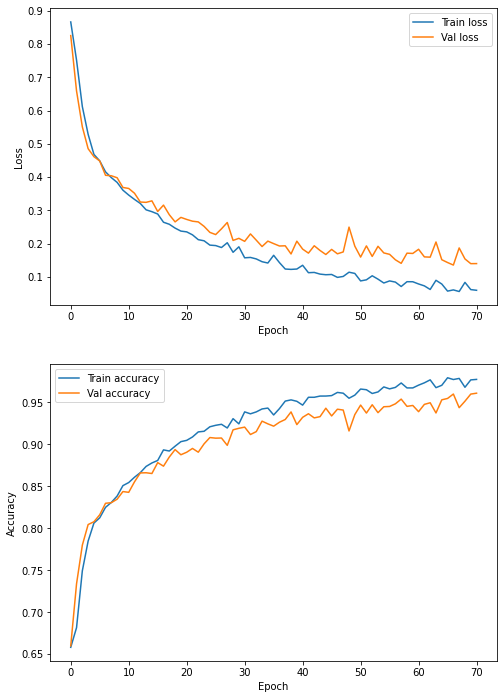

In [ ]:
# visualize history - trail1
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
            label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
            label='Train accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val accuracy')
    plt.legend()
plot_history(cnn_history)

In [28]:
# save model
cnn.save("./models/3d_Giga_aug_Yrep_rand_split_dropoutX.h5")


## Model Evaluate


- metastasis: 1
- HCC: 2
- cholangiocarcinoma: 3



In [11]:
# model load하는 경우
cnn  = tf.keras.models.load_model("./models/3d_Giga_aug_Yrep_rand_split_dropoutX.h5")

In [13]:
def output_class(x):
    output = np.argmax(x)
    if output == 0:
        return 'metastasis'
    elif output == 1:
        return 'HCC'
    elif output == 2:
        return 'cholangiocarcinoma'
        
from sklearn.metrics import confusion_matrix
y_pred = cnn.predict(X_i_te)    
y_true=pd.DataFrame(Y_te_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)

In [14]:
Y_te_cat.shape

(16092, 3)

In [15]:
conf_matrix = pd.DataFrame(confusion_matrix(y_true, y_pred_classified),index=['metastasis','HCC','cholangiocarcinoma'],
                           columns=['metastasis','HCC','cholangiocarcinoma'])
conf_matrix

,metastasis,HCC,cholangiocarcinoma
metastasis,3127,48,293
HCC,34,1896,110
cholangiocarcinoma,216,137,10231


In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classified))

                    precision    recall  f1-score   support

               HCC       0.93      0.90      0.91      3468
cholangiocarcinoma       0.91      0.93      0.92      2040
        metastasis       0.96      0.97      0.96     10584

          accuracy                           0.95     16092
         macro avg       0.93      0.93      0.93     16092
      weighted avg       0.95      0.95      0.95     16092



In [19]:
from sklearn.metrics import confusion_matrix
y_pred = cnn.predict(X_i_tr)    
y_true=pd.DataFrame(Y_tr_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)

conf_matrix = pd.DataFrame(confusion_matrix(y_true, y_pred_classified),index=['metastasis','HCC','cholangiocarcinoma'],
                           columns=['metastasis','HCC','cholangiocarcinoma'])
conf_matrix

,metastasis,HCC,cholangiocarcinoma
metastasis,33931,1991,20090
HCC,1189,24897,8002
cholangiocarcinoma,6053,4052,162547


In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classified))

                    precision    recall  f1-score   support

               HCC       0.82      0.61      0.70     56012
cholangiocarcinoma       0.80      0.73      0.77     34088
        metastasis       0.85      0.94      0.89    172652

          accuracy                           0.84    262752
         macro avg       0.83      0.76      0.79    262752
      weighted avg       0.84      0.84      0.84    262752



## Post Process

In [ ]:
label_list = ["metastasis","HCC","cholangiocarcinoma"]
y_pred = cnn.predict(X_i_te)   
X_i_te.shape, y_pred.shape

In [ ]:
def concate_patches(start_idx,overlap=False):
    temp1 = np.concatenate((X_i_te[start_idx,:,:,:].sum(axis=2),X_i_te[start_idx+1,:,:,:].sum(axis=2)), axis=1)
    temp2 = np.concatenate((X_i_te[start_idx+2,:,:,:].sum(axis=2),X_i_te[start_idx+3,:,:,:].sum(axis=2)), axis=1)
    temp_result = np.concatenate((temp1,temp2),axis=0)
    if overlap:
        temp_result = temp_result[:,:,0]+temp_result[:,:,1]+temp_result[:,:,2]+temp_result[:,:,3]+temp_result[:,:,4]
    return temp_result
concate_patches(0).shape


(64, 64)

In [ ]:
patches_no_per_image = 4
def concatenate_Xs(patches_no_per_image,X_i_te):
    x_list = []
    x_img_cnt = X_i_te.shape[0]//patches_no_per_image
    for i in range(x_img_cnt):
        x_list.append(concate_patches(i*patches_no_per_image))
    x_list = np.array(x_list)
    return x_list
X_concat = concatenate_Xs(patches_no_per_image,X_i_te)

X_concat.shape

(3078, 64, 64)

In [ ]:
patches_no_per_image = 4

def concatenate_Ys(patches_no_per_image,y_pred):
    y_list = []
    y_img_cnt = y_pred.shape[0]//patches_no_per_image
    for i in range(y_img_cnt):
        y_temp = np.mean(y_pred[i*patches_no_per_image:(i+1)*patches_no_per_image,:],axis=0)
        # y_temp = np.zeros(shape=(patches_no_per_image))
        # for j in range(patches_no_per_image):
        #     y_temp += y_pred[patches_no_per_image*i+j]
        y_list.append(y_temp)
    y_list = np.array(y_list)
    return y_list
Y_concat=concatenate_Ys(patches_no_per_image,y_pred)
print(Y_concat.shape)

(10329, 3)


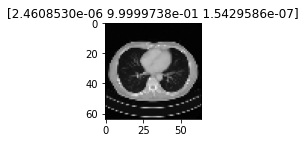

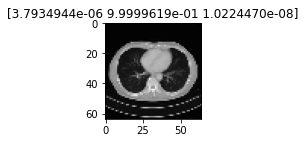

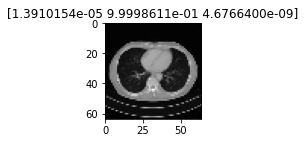

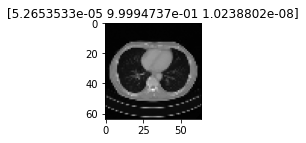

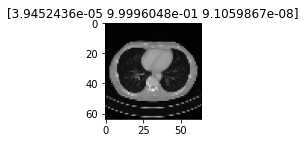

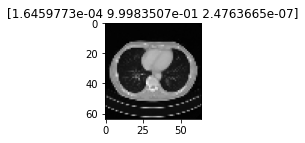

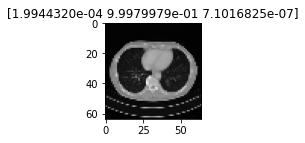

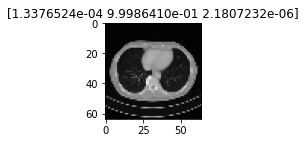

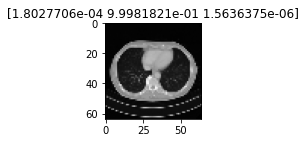

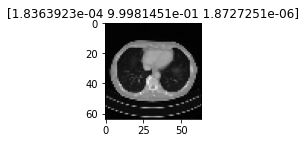

In [ ]:
10개만 보여주기
cnt = 1

for x, y in zip(X_concat,Y_concat):
    fig=plt.figure(figsize=(10,10))
    fig.add_subplot(2, 5, cnt)
    plt.title(f"{y}")
    plt.imshow(x, cmap='gray')
    if cnt ==10:
        break
    cnt +=1